# $\mathbf{TAKE}$ $\mathbf{THE}$ $\mathbf{SHOT}$ $\mathbf{OR}$ $\mathbf{NOT?}$
## *Shot Caller for Ballers: 3-point shooting analysis and success modeling*  
### Prepared for The NBA Advanced Statistics Forum

$\rightarrow$ Report by Jen Eyring, Ryan Miller and Lincoln Muriithi | Analytics & Data Science Team | 8/19/2022

----

# 🏀 Introduction

### The NBA, like most sports, is rich with data.  For years, coaches and players used rudimentary game analysis - and more often their 'gut' - for decision making.  However, starting with the 2013-2014 season, the NBA formalized data collection across the league by putting six cameras in every arena.  These cameras each capture the position of each player and the ball 25 times per second. In 48 minutes of action, that's more than [4 million total data points per game](https://www.newsweek.com/nbas-new-technology-will-change-way-we-watch-sports-563#:~:text=During%20every%20NBA%20game%2C%20six,total%20data%20points%20per%20game).  In addition to providing teams with this data, the NBA has made this data publicly available.

<a id="execsummary"></a>

# 🏀 Executive Summary

### Question: With the rich data captured by the league, what factors influence three point shooting success?  And can we find features defining a general, leaguewide model which predicts whether or not a three point shot will go in?  Said another way, *should they take the shot or not?*

### Why It's Important: Teams that win have a mean 3 point percentage of 38.7% over the past 10 years, while those who lose average 32.3% from three (a 6.4% difference).

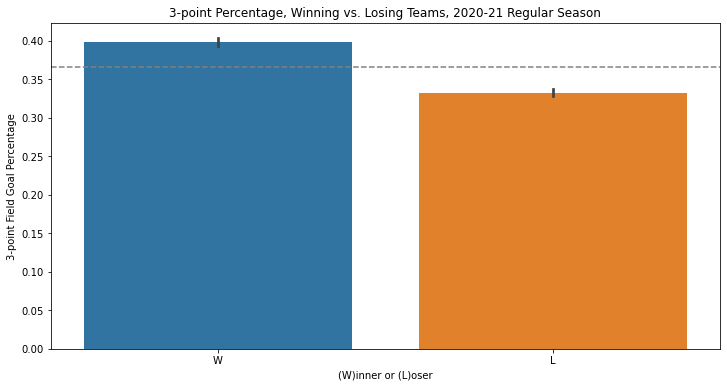

p/2 = 4.129281682776808e-79 (t = 19.59375713245642)
Null hypothesis rejected - the mean 3-point percentage is the higher for winning teams.


season,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19,2020-21,cumulative
winner_3pct,0.385,0.377,0.389,0.390,0.378,0.383,0.391,0.389,0.385,0.399,0.387
loser_3pct,0.322,0.311,0.322,0.324,0.317,0.320,0.322,0.333,0.325,0.332,0.323
difference,0.063,0.066,0.068,0.066,0.061,0.063,0.068,0.056,0.061,0.066,0.064


In [20]:
# Creates dataframe showing winning vs. losing team's mean three point percentage over each season and the past 10 years.
# Note - run libaries below first before executing this line of code.
winner_3pct()

### Actions: Using official stats from the NBA.com/stats database, with endpoints accessed through a third party API client, we collected data on shot taken in the 2021-2022 season and filtered for three point shots.  This data includes a number of in-game and player specific features, including both raw data and engineered features.  After an in-depth analysis, we split the dataset into training, validation and unseen test sets and applied a 

### Conclusions:  We discovered that [the following are statistically signifigant] Even with extensive analysis, for a general leaguewide model we were only able to beat baseline by 0.3%.  However, when modeling.

### Recommendations: Continue to cluster stellar characteristics in an attempt to find one statistically signifigant as an indicator of Earthlike planets.  Also, an imputing algorithm can be used to capture a number of planets that had nulls that could not be filled simply by combing and finding the mean of all available data for that planet.  Lastly, focus early JWST studies on building a dataset which allows for modeling the likelihood of a star having an earthlike planet, as this will make it a better tool in the long run by continually improving its targeting.

## Report Contents:
- ### [Executive Summary](#execsummary)
- ### [Libraries](#libraries)
- ### [Data Acquisition and Summary Analysis](#dasa)
- ### [EDA and Feature Engineering](#EDA)
- ### [Modeling](#modeling)
- ### [Conclusions](#conclusions)

***

 <a id="libraries"></a>

# 🏀 Libraries Required for Analysis

Common DS Libraries

In [2]:
# For data analysis:
import numpy as np
import pandas as pd

# Graphs/Visualizations:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# For Statistics and Hypothesis Testing:
import scipy.stats as stats

# For Modeling:
from itertools import combinations
from itertools import product
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# Necessary Modules
import os
import time

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


NBA API Endpoint Grabbers

In [ ]:
from nba_api.stats.static import teams
from nba_api.stats.static import players
from nba_api.stats.endpoints import gamerotation
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import teamplayerdashboard
from nba_api.stats.endpoints import winprobabilitypbp
from nba_api.stats.endpoints import leaguegamefinder

Helper Functions

In [28]:
from acquire import tome_prep, all_21_22_shots, create_3pt_shot_zones
from wrangle import wrangle_prep, wrangle_prep_player, create_metrics
import explore
#from model import

Others

In [16]:
#Ignore Warnings:
import warnings
warnings.filterwarnings('ignore')

# reloads import files each time a cell is ran (makes your life easier)
%load_ext autoreload
%autoreload 2

# Shows all columns of a dataframe
pd.set_option('display.max_columns', None)

<a id="dasa"></a>

# 🏀 Data Acquisition and Summary Analysis

### Source description (NBA stats via API)

We acquired our data from the official [nba.com/stats](https://www.nba.com/stats/) database using a third party API client module called [NBA-API](https://github.com/swar/nba_api).  It is a powerful but complex tool to use, containing modules that link to a number of hidden endpoints on the stats page - 135 of them to be specific.  While the endpoints are largely undocumented and change frequently on the NBA side, the API has robust documentation and tracks the changes.  It can also return queried data as a dataframe, making manipulation and discovery much easier using pandas.

We used a number of endpoints, two of which are considered 'static'. To use, you call an endpoint and enter any required and optional parameters.  The endpoints we used are:
- Static (only requires a single API request to pull in entire datasets that change year to year)
    - Teams: Team/franchise data for all leagues, since league inception
    - Players: Player data for all leagues, since league inception
- Dynamic (updates with every game, some in-game)
    - gamerotation: For each game, gives the time periods when a player is in or out of the game.
    - shotchartdetail: For a given player in a given season, gives all of their shots by x- and y-location on the court (where x and y are measured in 1/10ths of feet).
    - teamplayerdashboard: Convenient for pulling the team(s) a player is on in a given season
    - winprobabilitypbp: Gives a second by second account of the game, along with win probabilities for each time at each second (until 300 seconds/5 mins remain, when it stops).
    - leaguegamefinder: Used to quickly pull a team's season-level stats to compare to other teams and across sesasons.

## Acquisition Steps (see 'acquisition_workbook.ipynb' for more detail)

Our analysis and model are focused on three pointers taken in the most recent (2021-2022) regular season.  Out goal was to acquire a dataframe that had every three point shot taken by eveyr player who took one, along with the result (Made or Missed) and a number of features calculated for the player and game right up to the moment the shot was taken.  The [Acquire Workbook](*/acquire.py) associated with this report contains the step by step process of building our initial, raw dataset.  In brief:
1. Get team-player data from 'teamplayerdashboard' endpoint and use it to acquire all shots taken in the '21-'22 Regular Season using shot information from the 'shotchartdetail' endpoint.
2. Isolate 3-pt shots from this data and remove outliers. We used shot distance, acquired from 'shotchartdetail', as the metric to determine outliers.  Outliers were shots from a distance 1.5 times the IQR of all three point shots.  This eliminated all shots 30 feet and beyond (2188 shots, or 2.5% of all three pointers).
3. Apply a KMeans clustering algorithm on all remaining three point attempts to identify the natural 'zones' from which players are shooting.  Using a k-elbow test we determined seven (7) clusteres were optimal, improving upon the NBA standard five (5) shot zones.

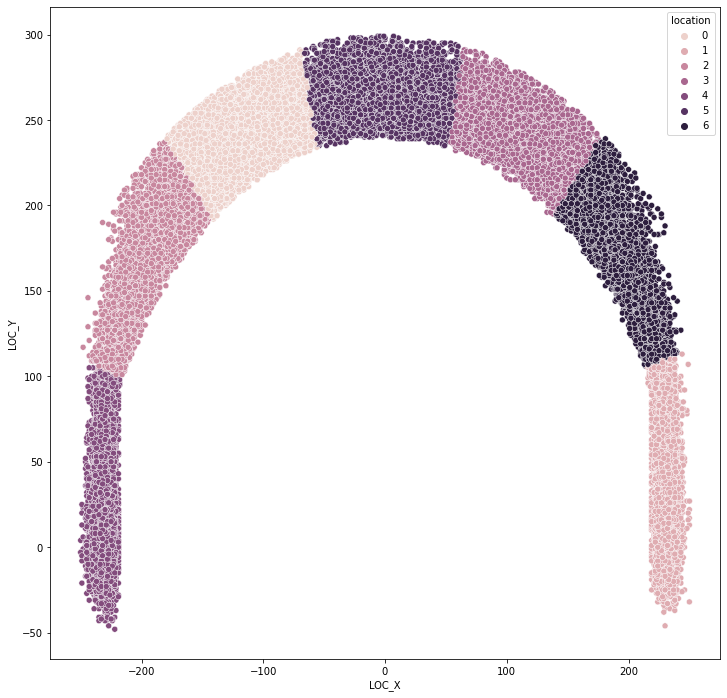

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,abs_time,zone
0,Shot Chart Detail,22100014,42,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,1,8,14,Made Shot,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,23,228,64,1,1,20211021,ATL,DAL,226,L Above Break
1,Shot Chart Detail,22100014,47,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,1,7,47,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,24,91,232,1,1,20211021,ATL,DAL,253,R Center
2,Shot Chart Detail,22100014,305,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,2,1,44,Missed Shot,Driving Floating Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,7,6,79,1,0,20211021,ATL,DAL,1336,NaN
3,Shot Chart Detail,22100014,362,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,3,9,40,Made Shot,Jump Shot,3PT Field Goal,Right Corner 3,Right Side(R),24+ ft.,23,228,69,1,1,20211021,ATL,DAL,1580,L Above Break
4,Shot Chart Detail,22100014,433,203992,Bogdan Bogdanovic,1610612737,Atlanta Hawks,3,4,24,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,24,134,210,1,0,20211021,ATL,DAL,1896,R Center
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216717,Shot Chart Detail,22100382,22,1630176,Vernon Carey Jr.,1610612766,Charlotte Hornets,1,10,50,Made Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,2,11,1,1,20211210,CHA,SAC,70,NaN
216718,Shot Chart Detail,22100382,36,1630176,Vernon Carey Jr.,1610612766,Charlotte Hornets,1,9,8,Missed Shot,Cutting Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,9,23,1,0,20211210,CHA,SAC,172,NaN
216719,Shot Chart Detail,22100382,40,1630176,Vernon Carey Jr.,1610612766,Charlotte Hornets,1,8,53,Made Shot,Reverse Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,5,17,1,1,20211210,CHA,SAC,187,NaN
216720,Shot Chart Detail,22100382,48,1630176,Vernon Carey Jr.,1610612766,Charlotte Hornets,1,8,11,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Center(C),16-24 ft.,19,38,193,1,0,20211210,CHA,SAC,229,NaN


In [17]:
# Shows all shots clustered into shot zone.  
# Note - ensure 'all_last_season_shots.csv' is in the directory, or else this will begin an API request.
df_shots = all_21_22_shots()
create_3pt_shot_zones(df_shots)[0]

4. Using the 'winprobabilitypbp' endpoint, get a second-by-second record of all 2,460 regular season games.  Since games are measured in minutes and seconds, create an absolute time feature to merge this and all other acquired dataframes on.
5. Using the 'gamerotation' endpoint, find the times every player was on the court in every game.  Use absolute time to link it to when their shots occured.
6. Combine the previous two steps to get a second by second accounting of playing time for each game the player plays in and remove all times the player was not invovled in a three point shot.  This data is then cleaned up removing non-impactful features.
7. Repeat the previous step for every game a player plays in.
8. Repeat the entire process for every player and perform last minute cleaning, to include removing features that are not helpful.
9. Return an initially cleaned dataframe with all three point shots taken, their result, and other in-game and player features up to that shot in the season.

Note: This process requires a lot of requests and merging of data from various places within the NBA stats database.  While we pulled dform the API, we created save points as the process would often timeout.  We then collected all the data into what we called the 'tome', hence the name of our full acquire function 'tome_prep'.  We cached this data into a local csv.

In [6]:
# Acquires the dataframe of all three point shot attempts, adding zones from clusters and removing outliers.
# Note - ensure 'league_3pa.csv' is in the directory, or else this will begin a very long, full API request process.
df = tome_prep()
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84164 entries, 0 to 84163
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player        84164 non-null  object 
 1   player_id     84164 non-null  int64  
 2   team          84164 non-null  object 
 3   team_id       84164 non-null  int64  
 4   game_id       84164 non-null  int64  
 5   home          84164 non-null  bool   
 6   period        84164 non-null  int64  
 7   abs_time      84164 non-null  int64  
 8   play_time     84164 non-null  float64
 9   since_rest    84164 non-null  float64
 10  loc_x         84164 non-null  int64  
 11  loc_y         84164 non-null  int64  
 12  zone          84164 non-null  object 
 13  shot_type     84164 non-null  object 
 14  score_margin  84164 non-null  int64  
 15  points        84164 non-null  int64  
 16  shot_result   84164 non-null  object 
dtypes: bool(1), float64(2), int64(9), object(5)
memory usage: 10.4+ MB


,player,player_id,team,team_id,game_id,home,period,abs_time,play_time,since_rest,loc_x,loc_y,zone,shot_type,score_margin,points,shot_result
79764,Isaiah Livers,1630587,Detroit Pistons,1610612765,22101169,False,4,2594,1810.0,222.0,110,228,R Above Break,Pullup Jump shot,10,8,Missed Shot
3719,Derrick White,1628401,San Antonio Spurs,1610612759,22100144,False,3,1843,1214.0,505.0,189,203,L Below Break/Corner,Jump Shot,-1,0,Missed Shot
4065,Grant Williams,1629684,Boston Celtics,1610612738,22100654,True,1,712,712.0,712.0,235,11,R Below Break/Corner,Jump Shot,-11,10,Missed Shot
68362,Ty Jerome,1629660,Oklahoma City Thunder,1610612760,22100522,False,1,479,479.0,479.0,124,266,R Above Break,Jump Shot,-1,12,Missed Shot
38274,Jrue Holiday,201950,Milwaukee Bucks,1610612749,22100273,True,1,459,459.0,459.0,-66,251,Center,Running Pull-Up Jump Shot,17,4,Missed Shot


## Acquired Data Descriptions

- player: Player's name (string)
- player_id: Unique player id (integer)
- team: Team the player plays for (string)
- team_id: Unique team id (integer)
- game_id: Unique game id (integer)
- home: Is the player's team home this game? (boolean)
- period: Period in which the shot took place (integer, values = 1-4)
- abs_time: Absolute game time, in seconds (integer)
- play_time: Total time the player has played in the game when the shot was taken, in seconds (integer)
- since_rest: Time since the player last rested, in seconds (integer)
- loc_x: The location to the right or left of the center of the basket, in 1/10th feet (integer, value ranges -250 to 250 with basket at x = 0
- loc_y: The location in front of (or behind) the center of the basket, in 1/10th feet (integer, value ranges -48 to 940 with basket at y = 0)
- zone: The three point zone from which the shot is taken, based on location and engineered clusters (string, 7 values)
- shot_type: The type of shot (string, 14 values)
- score_margin: Current score margin of players team when shot is taken (integer, negative values mean player's team is behind by that many points)
- points: Total points the player has scored up to when the shot is taken (integer)
- shot result [TARGET]: Whether the three point shot was Made or Missed (string, 'Made' or 'Missed')

## Notable dropped features in the acquisition process

In addition to the many endpoint columns we did not need, we determined the following were unnecessary going forward:
- win_prob: Win probability at the point of the shot.  Since it cuts off with 300 seconds remaining, cannot be usd effectively and cannot be imputed for close games.
- fg_type: Whether the shot was a 2pt or 3pt shot.  Needed previously to filter three point shots, no longer needed.
- fg_pct: Field goal percentage for the game.  Decided to create three point percentage for game later on as better metric.

<a id="EDA"></a>

# 🏀 Exploratory Data Analysis and Feature Engineering

## Pre-Processing - Wrangle (see 'wrangle_workbook.ipynb' for more detail)

For additional pre-processing/cleaning, we performed the following actions:
1. Create cumulative three point stats for all players across all games.
2. Add location back in using loc_x and loc_y (was lost in the acqusition process; this is also an improvement as it is a float and does not bin by integer foot)
3. Add back in 'game_event_id', as it is needed for the Tableau Dashboards
4. Encode categoricals, scale numericals, split into train/validate/test, and finally seperate the X (features) from the y (target)
5. Return the following dataframes:
    - df: Complete initial dataframe with pre-processing perfomed, used for Univariate Distribution Analysis
    - df_outlier: A dataframe containing the outlier three point shots, in case needed in future
    - X_train_exp: A dataframe for exploring the train data split (uneconded and unscaled)
    - X_train, X_validate, X_test: Scaled and encoded features for train/validate/test, used for bi/multivariate EDA and modeling
    - y_train, y_validate, y_test: Target (actual outcomes), used for bi/multivariate EDA and modeling

In [56]:
# Acquires all wrangled dataframes for analysis and modeling
# Note - since it runs acquire.tome_prep(), ensure league_3pa.csv' is in the directory
df, df_outlier_3pt, X_train_exp, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle_prep()

Train = 47167 rows (56.0%) | Validate = 20215 rows (24.0%) | Test = 16846 rows (20.0%)


### Notable dropped features in the X_ and y_ dataframes only, during wrangling (dropped after initial EDA)

- shot_types: The type of shot as recorded in the second by second record.  Turns out to be ambiguous and unhelpful.
- game_event_id: Not needed for analysis
- period (other than encoded period_4): As seen in the EDA below, only the fourth period was statistically signifigant.
- player, player_id, team, team_id, game_id: Cannot be modeled
- loc_x, loc_y: No longer needed with zone and distance features
- home_true, home_false: Statistically insignifigant
- game_3pa, game_3pm, game_3miss, cum_3pa, cum_3pm, cum_3miss: Used to create metric (discussed below) and no longer needed for analysis as their impace is captured by the metric
- cum_3pct, tm_v1, tm_v3: Individual player thre point shooting ability metrics we created that were unused (tm_v2 was the superiord metric)

## Metric Creation

We discovered that the only three point metric to compare playes with one another is three point percentage(3PCT).  As we wanted to capture and individual players idiosyncratic three point attributes, we sought a comparison metric to use.  Like baseball stats, the first major sport to use analytics heavily, we sought a composite metric that awarded playes for three point attempts and makes, and penalizes them for three point misses.

Examing a number of potential compostite metrics we developed the following, which was labeled tm_v2 during our process (three metric version 2) but we call the 'Jem-metric' after our amazing Codeup cohort and its namesake:

# $\frac{\frac{3pm^{2} + (3pm +3pa)}{2 * 3pa}}{N_{games}+1}$

where,

$3pm$ = three pointers made

$3pa$ = three pointers attempted

$N_{games}$ = Number of games played (the '1' is added to account for current game)

This equation is equal to a modified three point percentage (add half of the missed shot percentage into the made percentage).  It awards those who hit a lot of threes, but who also take a lot, as our domain knowledge informs us that playes who take a lot are 'allowed' to by their coaching staff because they know the player is a strong three point shooter (and the player has the confidence to take those shots).

Note: The metric is calculated for each individual game, and then the mean of all games up to that point are averaged to get the score going into the game.  The score immediately before the shot is then updated with the in-progress metric for the game.  The weakness to this is it takes a number of games (around 30) for the metrics error to stabilize.

Finally, as seen in the univariate distributions below, it was the most normal of the metrics we analyzed.

## Univariate Distributions

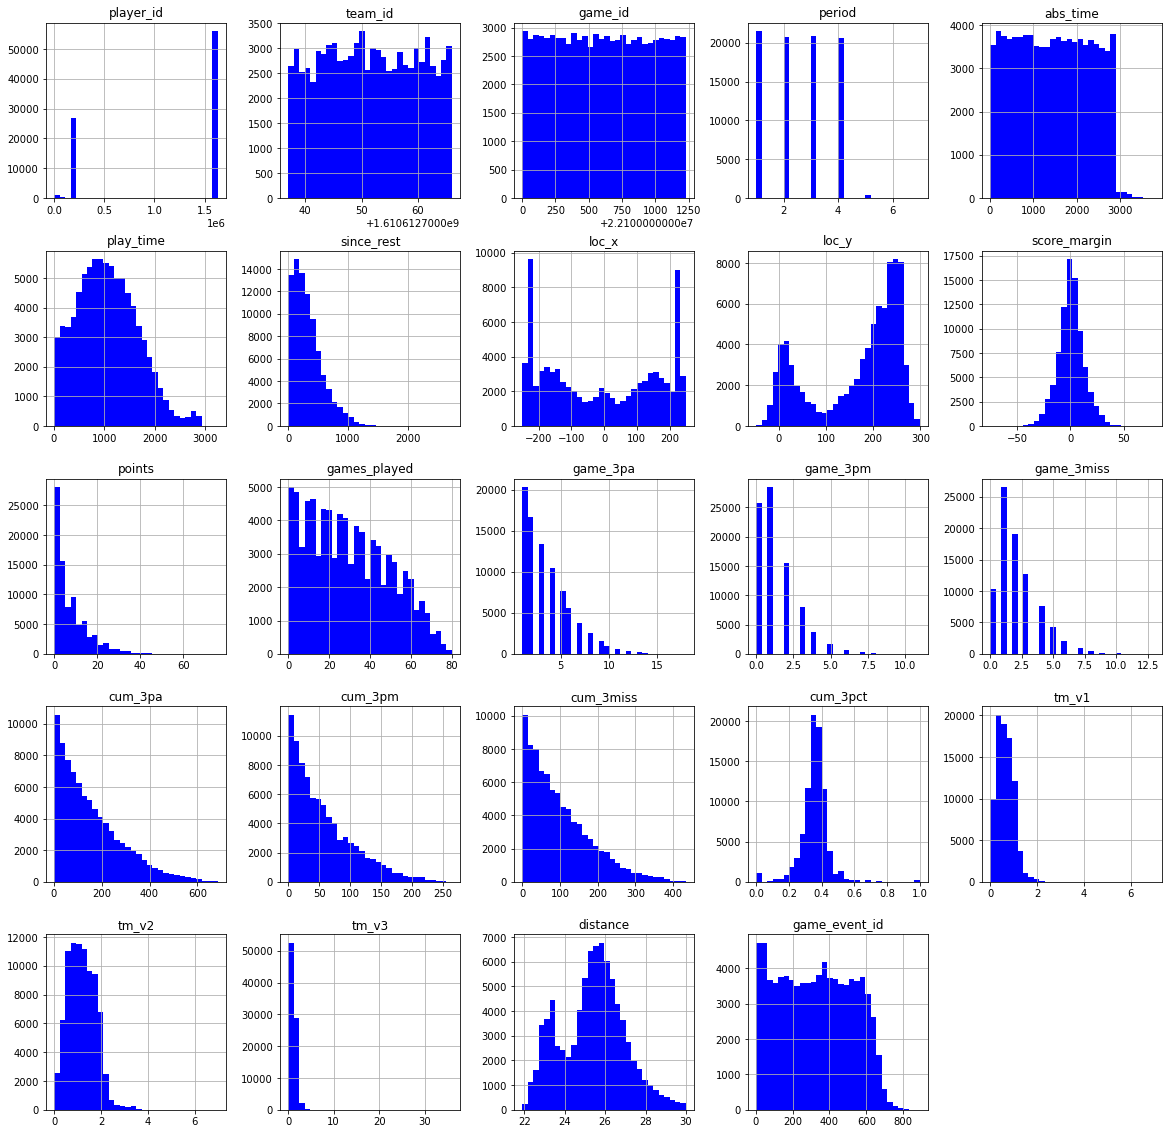

In [27]:
univariate(df)

> ### Distribution Key Takeaways:
> #### 1. Majority of the players have a mean play_time of  "1000 minutes" the distribution is skewed towards players resting earlier than not. 
> #### 2. Score_margin seems to be normally distributed with majority of the teams playing within a margin of -10 and +10 points.
> #### 3. Shooting distance also seems to show that majority of the shots are taken within the 23 and 26 feet range.

## Bivariate EDA using X_train_exp

### Correlations between features

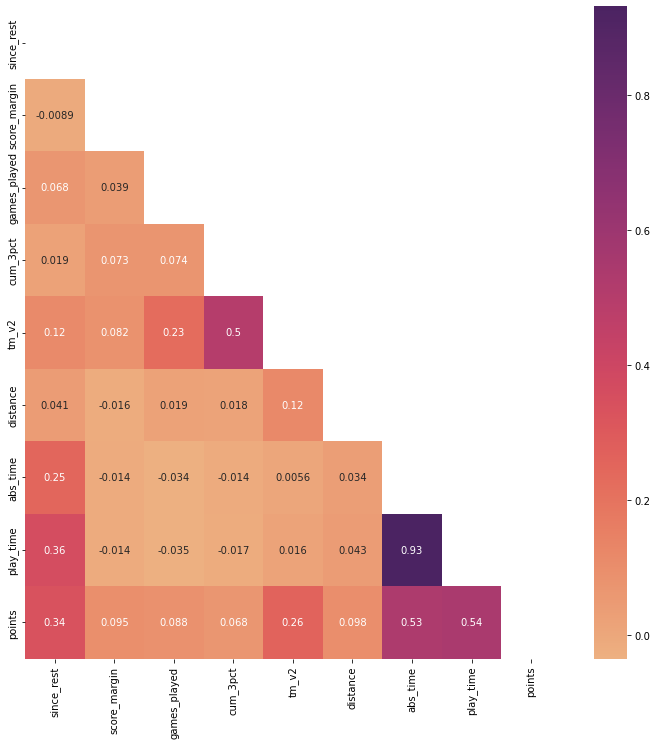

In [35]:
explore.heatmap(X_train_exp)

> ### Heatmap Key Takeaways:
> #### 1. Cumulative thre point percentage Cum_3pct and our metric tm_v2 are correlated, which makes sense, since 3pct is part of tm_v2.   
> #### 2. Points is correlated to abs_time and play_time (which are natrually highly curated to one another) which also makes sense.  
> #### 3. Since_rest is correlated with points as well, as longer times since rest means more playing time. however it is not correlated with cum_3pct meaning more rest doesn't seem to have an effect on three point shooting ability.  
> #### Overall no surprises here, and we should remove one or more of the time metrics.

### Exploring categorical variables for the season

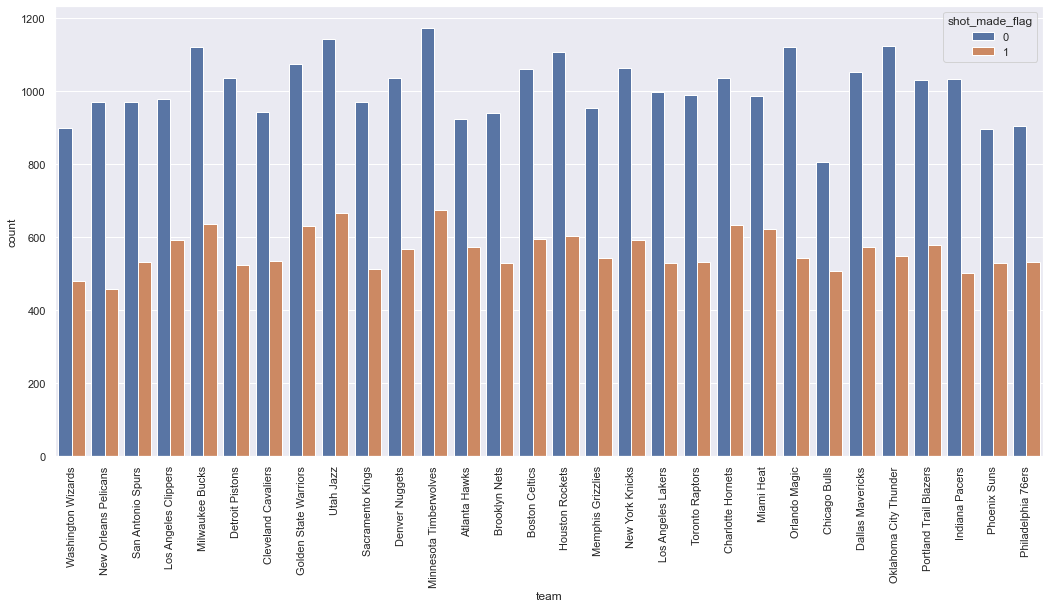

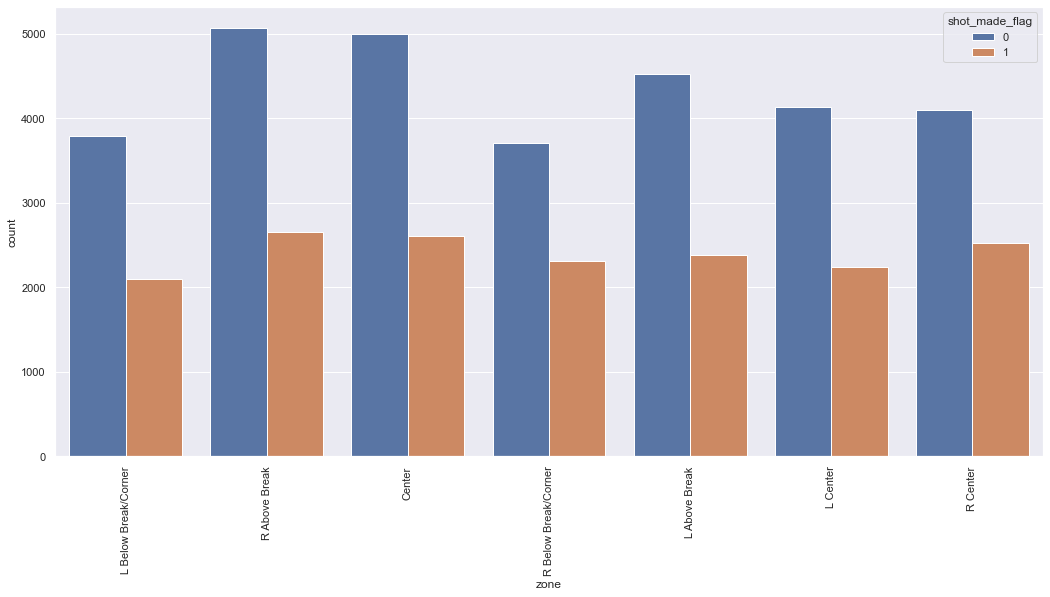

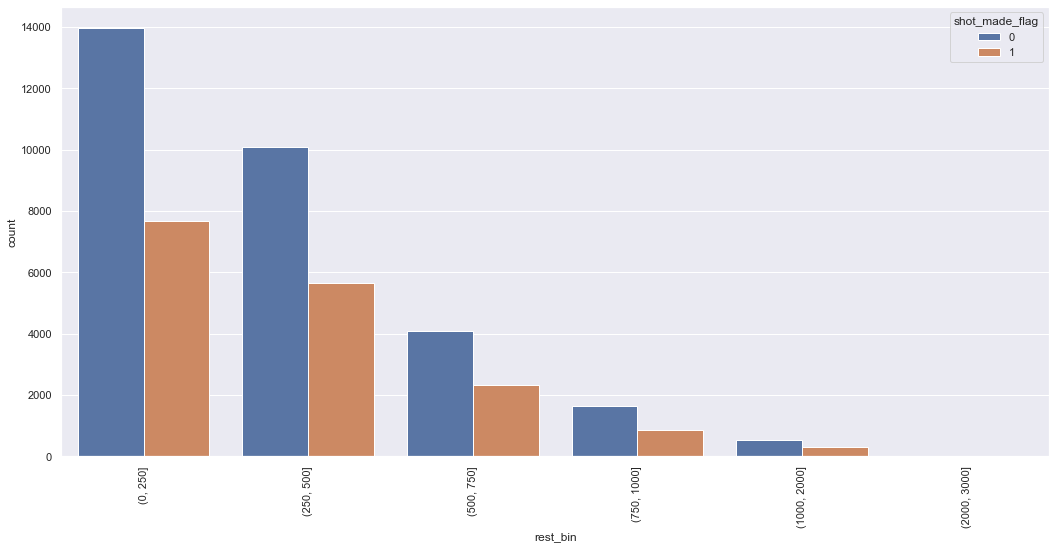

<AxesSubplot:xlabel='rest_bin', ylabel='count'>

In [74]:
explore.plot_categorical(X_train_exp)

> ### Season Categorical Key Takeaways:
> #### 1. The first chart illustrates how teams shot across the league
    - Certain teams like the Warriors and the Timberwolves stick out, having shot more threes than            other teams
> #### 2.  The second chart shows a distribution of the shots across the 3 point zones 
    - It appears that the most popular zones are the center and right above break
    - The least popular zone right below break/corner 
> #### 3. The third chart shows the preferred  3 point shot types for the season
    - majority of the league's shots were in the jump shot and pull up jumpshot category. This feature might not be as predictive to our model so it might be a candidate for feature elimination

### Exploring Categorical Variables Against Target

We plotted all categoricals vs target and ran Chi-Squared tests on all.

#### Home vs Target

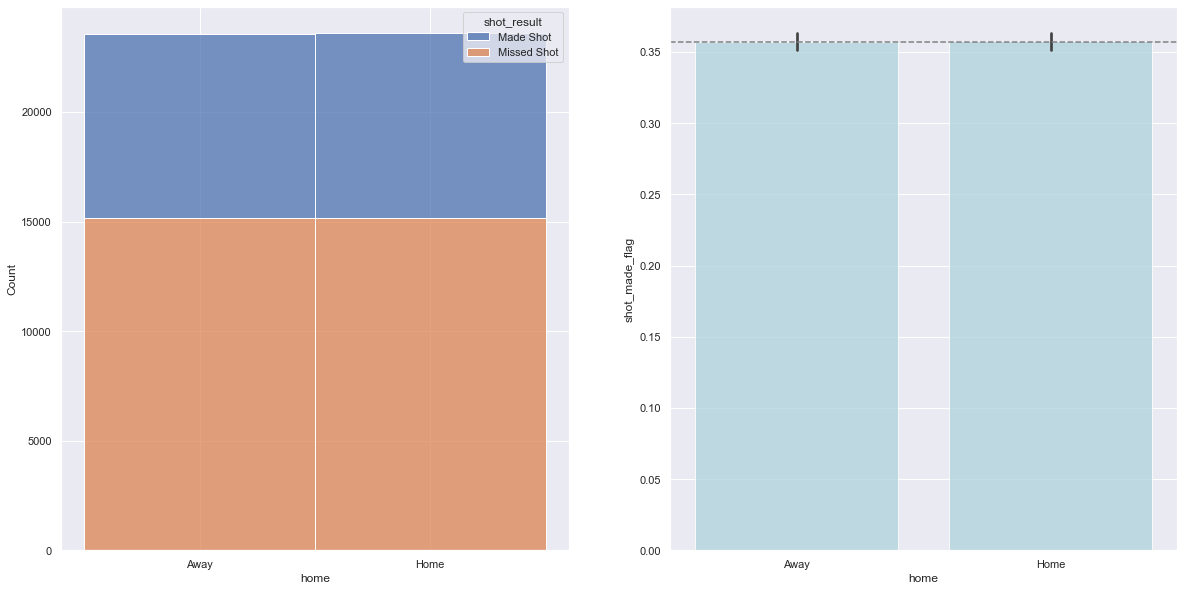

Chi-square = 0.027377924884132168
p = 0.8685797591403985, fails to reject the null hypothesis.


In [76]:
explore.home_vs_target(X_train_exp)

> ### Key Takeaway - 3pt shooting percentage is independent of being on the road or at home.

#### Period vs Target

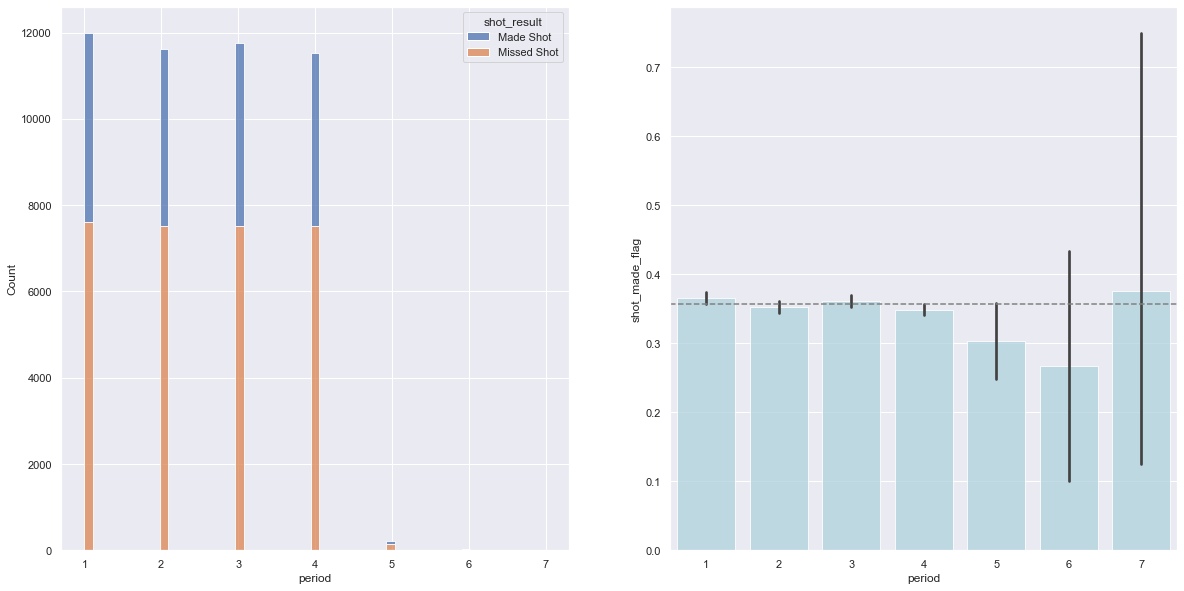

Chi-square = 0.027377924884132168
p = 0.8685797591403985, fails to reject the null hypothesis.


In [65]:
explore.period_vs_target(X_train_exp)

> ### Key Takeaway - there is a slight dependence of 3pt shooting on period, it appears mostly in the fourth quarter.  Overall, even though this fails to reject the null hypothesis, beyond saying 3pt shooting slightly ebbs in the fourth quarter we do not feel it is impactful.  We believe there may be more fourth quarter 'outlier' shots, outliers in that they aren't captured as outliers but are shots that are either rushed a bit to catch up in score if the player is down, or simply taken by a player when they are up big to practice a shot spot.

#### Zone vs Target 

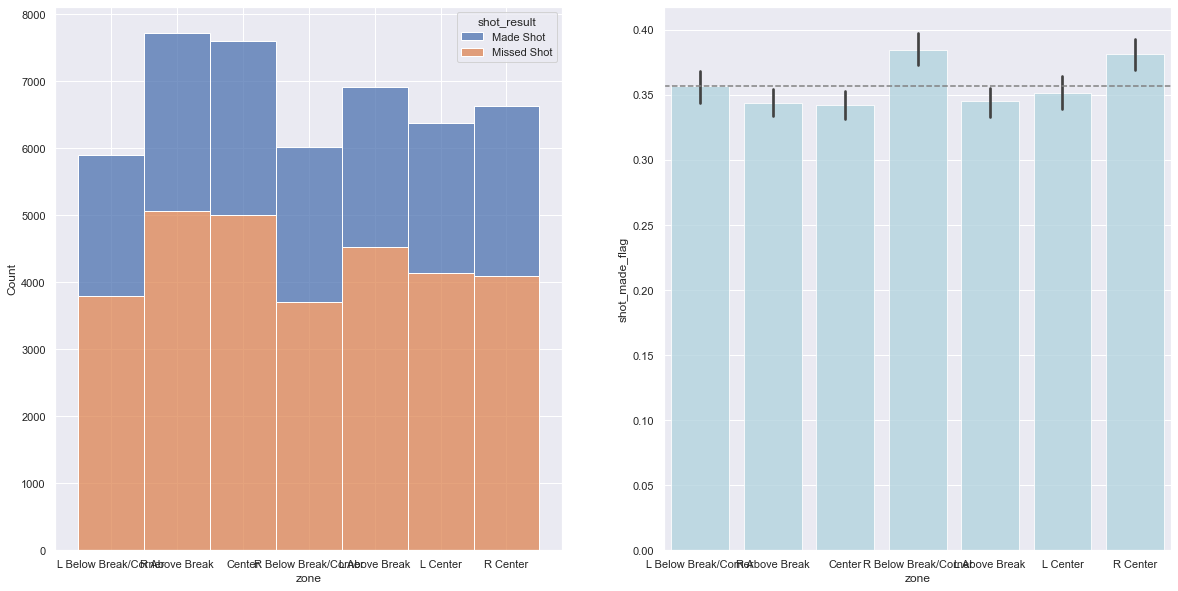

Chi-square = 0.027377924884132168
p = 0.8685797591403985, fails to reject the null hypothesis.


In [66]:
explore.zone_vs_target(X_train_exp)

> ### Key Takeaway - Looking at the chart, we see that hitting a 3pt shot is dependent on shooting location.  If shooting from below the break/corner on either side, players hit threes at or above average rate; right center is also a higher than mean probability shot.  A left center shot is within the confidence interval of the mean but on average is lower, and right above break, left above break and center are the lowest percentage of threes - althought they also represent the most threes shot so it could mean that defeneses have adjusted to those higher three point attempt zones - either because they know they are harder to hit, or because they know other shots, such as the corner, are easier to hit so they defend those places harder.

### Exploring Continuous Variables Against Target

*We ran plotted all continuous variables against the target.  After examing the charts, we dove deeper and t-tested five of the features.*

##### First check t-test Assumptions:
- Indepedent? - YES, tm_v2 which includes 3pt shot data uses data from *before* the shot being analyzed.
- Normally Distributed? - YES, the only feature that isn't normally distributed is games played, but there are enough datapoints here to satisfy the central limit theorem.
- Equal variances? - Yes, all variances are close:

In [87]:
# Check variances for T-Tests
for i in ['distance','tm_v2','since_rest','score_margin','games_played']:
    print(f'{i} variances:','Made:',X_train_exp[X_train_exp.shot_result == 'Made Shot'][i].var(),' Missed:',X_train_exp[X_train_exp.shot_result == 'Missed Shot'][i].var())

distance variances: Made: 2.493132458256492  Missed: 2.508762250540079
tm_v2 variances: Made: 0.34168733122309514  Missed: 0.3569052547455416
since_rest variances: Made: 59764.81340611715  Missed: 62816.30713581885
score_margin variances: Made: 137.96665412462073  Missed: 141.42858078459133
games_played variances: Made: 392.53915795324485  Missed: 381.6564513199287


#### Distance vs Target

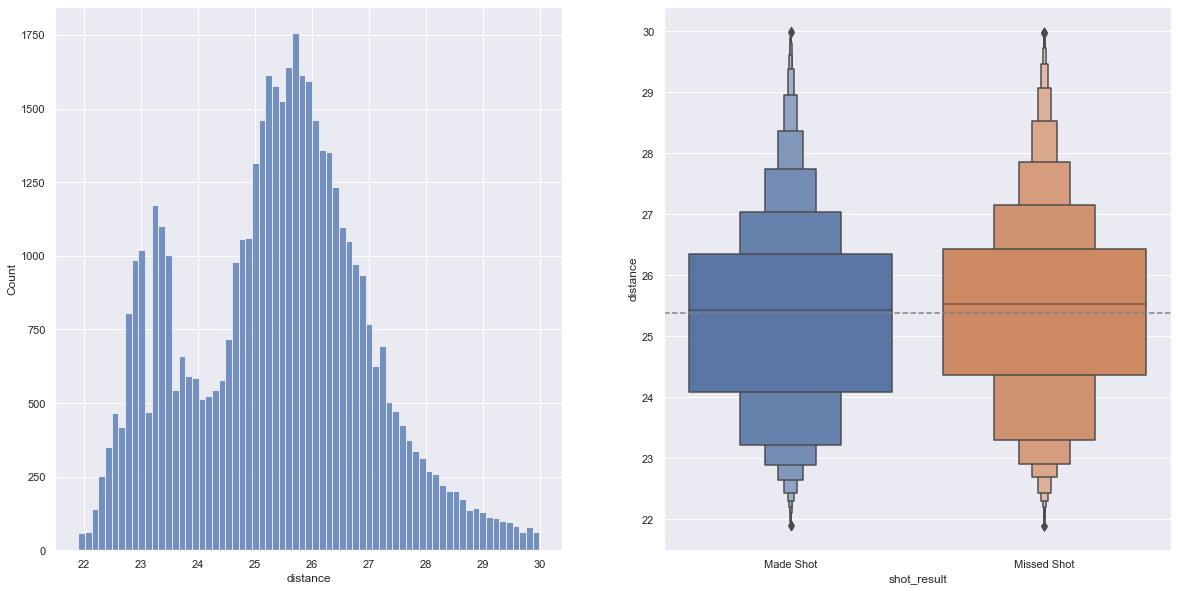

t = -7.177195052233609
p = 7.22023461387387e-13, reject the null hypothesis.


In [79]:
explore.distance_vs_target(X_train_exp)

> ### Key Takeaway - We reject that null hypothesis that shooting from a further distance has an equal or greater probability of hitting the shot than from shooting at a closer distance.  Therefore, players are better when shooting from a close distance (correlates with zones, as the below break/corner 3pt shots are at a closer distance.

#### Created Metric vs Target

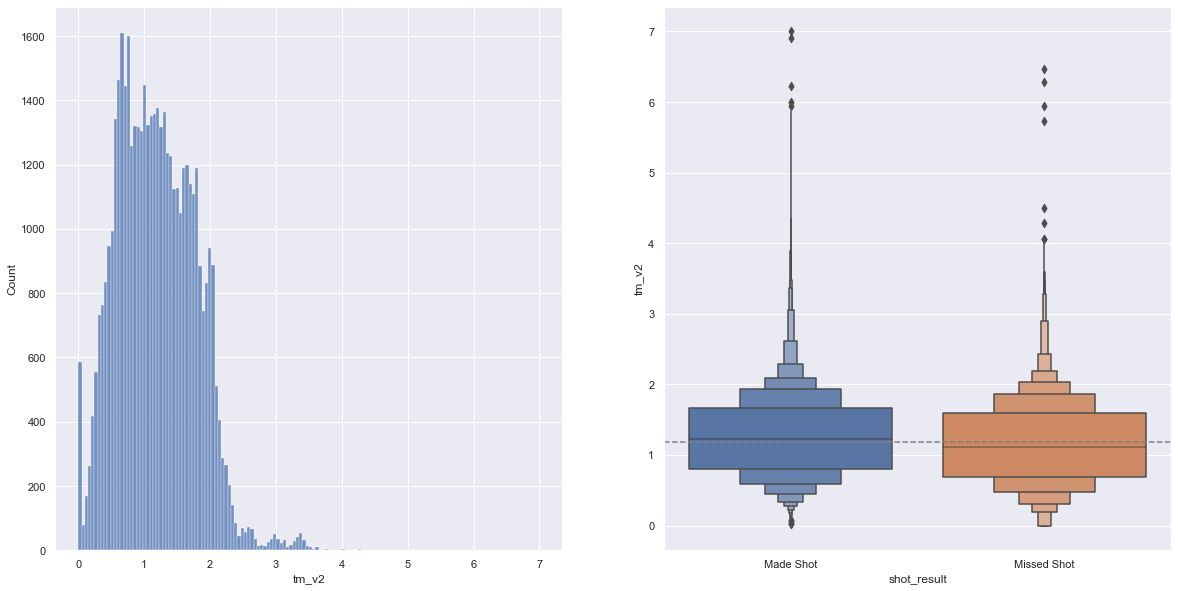

t = 19.41388595983995
p = 1.250579162237694e-83, reject the null hypothesis.


In [80]:
explore.tmv2_vs_target(X_train_exp)

> ### Key Takeaway - We reject that null hypothesis that players who make shots have the same or lower tm_v2 score than those who miss shots.  Therefore tm_v2 score is a good indicator of whether a player hits a three point shot.

#### Rest vs Target

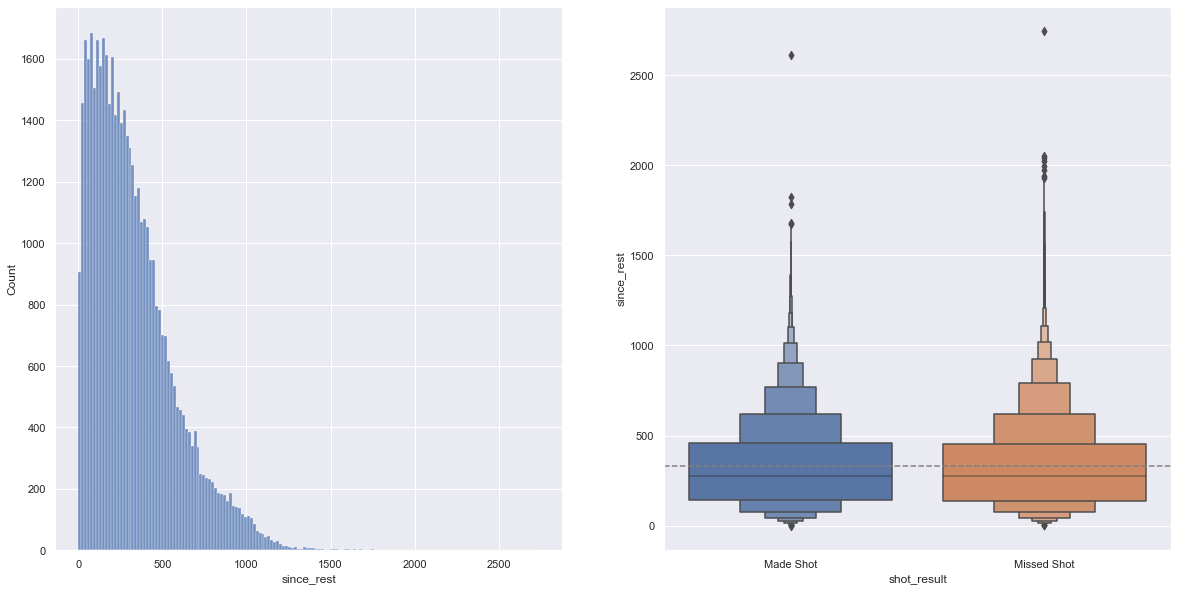

t = 0.05927963560613621
p = 0.952729632163387, fail to reject the null hypothesis.


In [82]:
explore.rest_vs_target(X_train_exp)

> ### Key Takeaway - We fail to reject the null hypothesis that players with the same or longer time since rest hit 3pt shots with the same percentage as those with less time since rest.  We strongly suspected that time since rest would have a negative impact on hitting a three, but it does not.

#### Score Margin vs Target

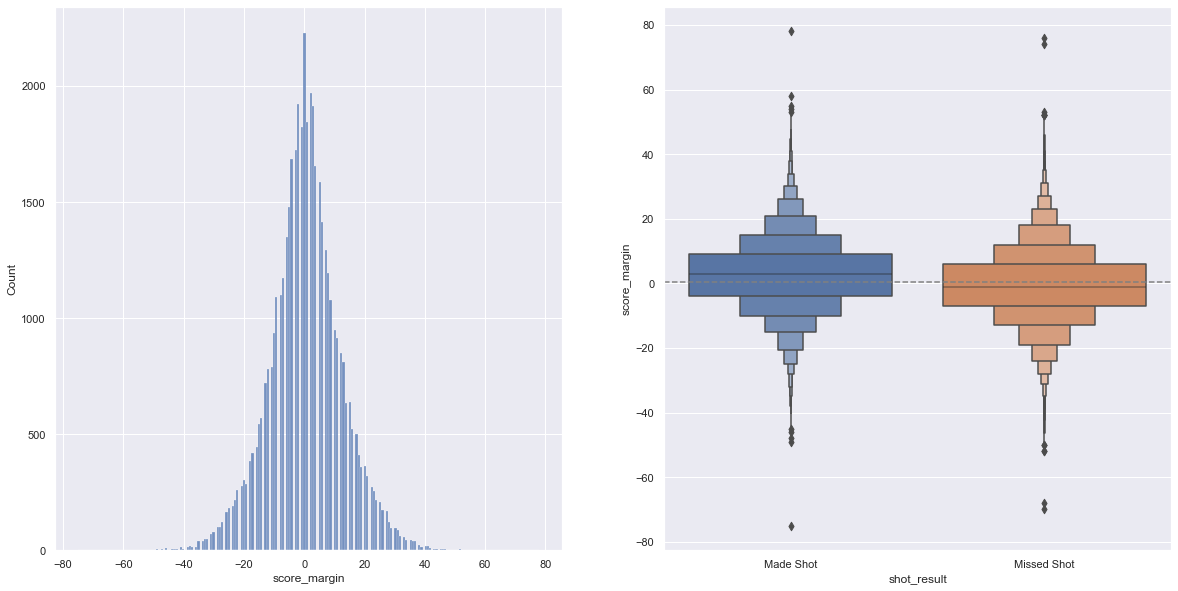

t = 28.22832375484482
p = 7.3878006985133915e-174, reject the null hypothesis.


In [84]:
explore.score_margin_vs_target(X_train_exp)

> ### Key Takeaway - We reject the null hypothesis that there is no difference in 3pt shot making ability when having a lower or the same score margin.  Therefore, when up in score, players seem to have more confidence in their shots, and hit more.

#### Games Played by Player vs Target

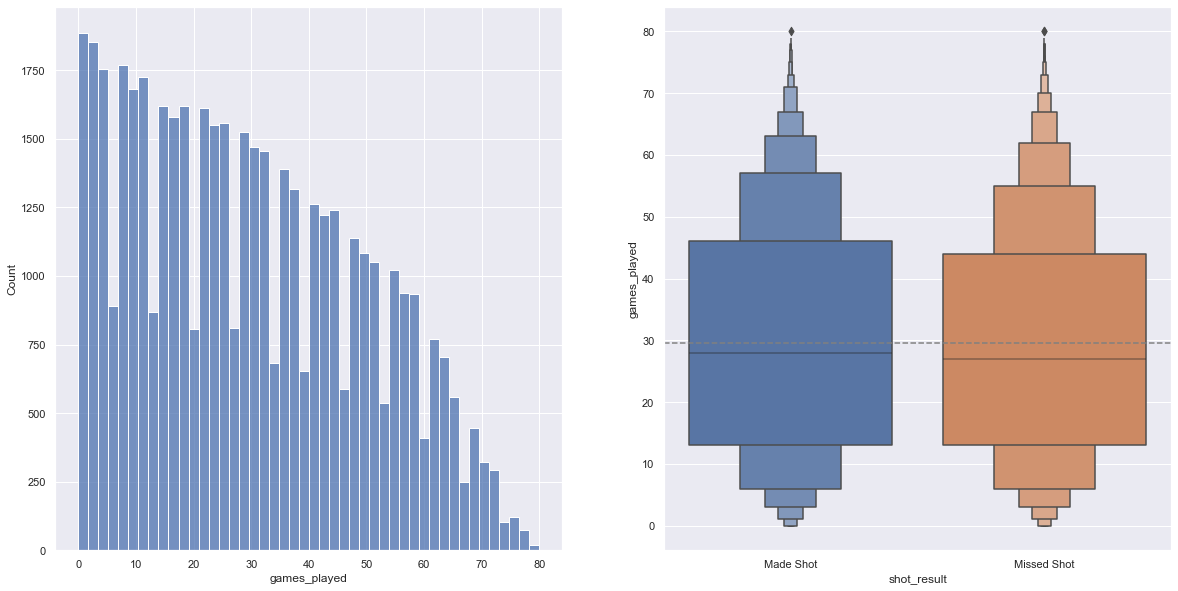

t = 4.590733982867856
p = 4.428279561594994e-06, reject the null hypothesis.


In [85]:
explore.games_played_vs_target(X_train_exp)

> ### Key Takeaway - We reject the hypothesis that 3pt shooting is the same between players with different games played.  Players who play more games typically have a higher shot percetnage.  Makes sense since those playing more games are typically better shooters. Especially since our dataset is only 3pt shooters.

### Elite Player Analysis

Using our Jem-Metric (tm_v2) we can identify the elite three point shooters in the league by detemrining who have the highest Jem-metric scores.  Note - we use the entire df to determine this.

In [95]:
elite_list = explore.find_elites(df)
elite_list

Index(['Anthony Edwards', 'Buddy Hield', 'CJ McCollum', 'Carmelo Anthony',
       'D'Angelo Russell', 'Desmond Bane', 'Devonte' Graham',
       'Donovan Mitchell', 'Duncan Robinson', 'Evan Fournier', 'Fred VanVleet',
       'Gary Trent Jr.', 'Grayson Allen', 'Jaylen Brown', 'Klay Thompson',
       'LaMelo Ball', 'LeBron James', 'Lonzo Ball', 'Luke Kennard',
       'Malik Beasley', 'Patty Mills', 'Paul George', 'Seth Curry',
       'Stephen Curry', 'Terry Rozier', 'Zach LaVine'],
      dtype='object', name='player')

Any player or group of players metric(s) for the season can be graphed using the following function, and in this case we compare the first five of the elite list.

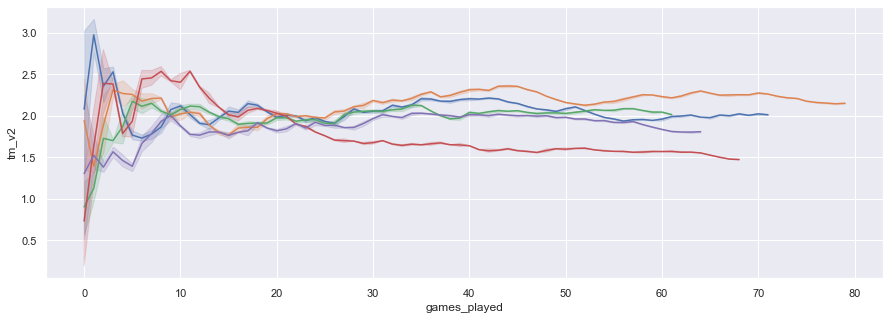

In [96]:
test_list = elite_list[:5]
explore.jem_graph(df, test_list)

<a id="modeling"></a>

# 🏀 Modeling

In [ ]:
# Process

In [97]:
X_train

,abs_time,play_time,since_rest,score_margin,points,games_played,tm_v2,distance,zone_Center,zone_L Above Break,zone_L Below Break/Corner,zone_L Center,zone_R Above Break,zone_R Below Break/Corner,zone_R Center,period_4
77133,0.639743,0.733971,0.086698,0.470588,0.000000,3,0.350000,0.499298,0,0,1,0,0,0,0,1
10088,0.099224,0.114471,0.137397,0.522876,0.000000,22,1.733049,0.732245,0,0,0,0,1,0,0,0
64509,0.204065,0.235421,0.182259,0.431373,0.078947,31,0.430970,0.542206,0,0,0,0,1,0,0,0
28690,0.531426,0.531317,0.420068,0.431373,0.184211,17,1.330409,0.556523,1,0,0,0,0,0,0,0
39117,0.017384,0.020056,0.025787,0.483660,0.000000,4,1.565385,0.124159,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,0.581706,0.509719,0.065543,0.437908,0.118421,1,2.031250,0.283530,0,0,0,0,0,1,0,1
75741,0.684675,0.527306,0.147974,0.503268,0.131579,30,1.313630,0.521001,0,0,0,0,1,0,0,1
38630,0.364269,0.281086,0.076850,0.320261,0.026316,1,0.600000,0.607010,1,0,0,0,0,0,0,0
22961,0.730142,0.489972,0.040376,0.542484,0.118421,11,1.890625,0.631258,0,0,0,1,0,0,0,1


Baed on EDA, we removed the following nefore modelign
- 

- Process
- Dropping features
- ensemble
- results - for general leaguewide model, x% better than baseline on unseen data
    - doesnt do much better, talk about accuracy vs precision vs. recall.  thus we tried it on individual players, starting with our elites
- Discovered even with the metric we built which we hoped would help predict the next shot, indivdiaul player idiosyncrazcites made it hard to model the league as a group.  Thus we decided to analyze this on individual players.
- Show dataframe with individual players
- Interestngly enough some players lend thmselves better to modeling than others.  Good next step for investigation.

In [ ]:
find_elites(df)

<a id="conclusions"></a>

# 🏀 Conclusions

Summary of biggest key takeaways

Recap of model Performance

Recommendations and Next Steps
- Dip deeper into NBA API to find additional features that were filter based.  Requires more computing power due to the complexity of the API calls needed
- Also run the ensemble modeling on every player to get a invidual view
- Add in additional years of data for veterans
- Limited this analysis to one year due to the time required to acquire the data.  Would love to acquire multipe eyars, especially for the individual player analysis